# Where to find referenced equations: 

[1] H. Owhadi and G. R. Yoo. Kernel flows: From learning kernels from data into the abyss. *Journal of Computational Physics*, 389:22–47, 2019. <br>
[2] B. Hamzi and H. Owhadi. Learning dynamical systems from data: a simple cross-validation perspective. *CoRR, abs/2007.05074* 2020.<br>
[3] F. Hoffmann, B. Hosseini, Z. Ren, and A. Stuart. Consistency of semi-supervised learning algorithms on graphs: Probit and one-hot methods. *Journal of Machine Learning Research 21*, 1-55, 2019

# Functions needed to compute u*

In [61]:
import scipy.optimize
import autograd.numpy as np
import autograd
from scipy.integrate import quad

# integral 
tmin = -10
tmax = 10 

# Functions for construction of problem

# Assume Noise i.i.d. logistic random variables with mean 0
def cap_psi(X, g):
    # g - gamma
    # cdf of zero-mean logistic random var
    return np.reciprocal(np.exp(-1.0/g*X)+1.0)

def psi(X,g):
    # g - gamma
    # pdf of zero-mean logistic random var
    return 1.0/g*np.exp(-1.0/g*X)*np.reciprocal(np.exp(-1.0/g*X)+1)**2

# [3]-(49)
def multi_psi_int(t, v, m, g):
    ret = psi(t, g)
    for i in range(v.size):
        if i != m:
            ret *= cap_psi(t- v[m] - v[i], g)
    return ret

def multi_psi(v,m,g):
    y, err = quad(multi_psi_int, tmin, tmax, args=(v,m,g))
    return y


def multi_partial_int(t, v, m, i, g):
    ret = psi(t, g)*psi(t + v[m] - v[i],g)
    for l in range(len(v)):
        if l != m and l != i:
            ret *= cap_psi(t - v[m] - v[l],g)
    return ret
    
def multi_partial(v, m, g):
    ret = np.zeros(v.shape)
    for i in range(v.size):
        if i != m:
            y, err = quad(multi_partial_int, tmin, tmax, args=(v,m,i,g))
            ret[i] = -y
        else:
            for k in range(len(v)):
                if k != m:
                    y, err = quad(multi_partial_int, tmin, tmax, args=(v,m,k,g))
                    ret[i] += y
    return ret
            
    
# Weight function returned by kernel Function
def weight(X, N_lst, r, eps):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    eps - gives perturbed kernel if eps != 0
    r - threshold in kernel function
    '''
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    N = N_lst.size
    W = np.zeros((N,N))
    for count_i,i in enumerate(N_lst):
        for count_j, j in enumerate(N_lst):
            # kappa function as L2 norm
#             X_i = X[i]; X_j = X[j]
#             dist = 0.0
#             for ix in range(X_i.size):
#                 dist += (X_i[ix]-X_j[ix])**2
            dist = np.linalg.norm(X[i]-X[j])**2
            if dist<=r:
                W[count_i][count_j] = 1
            W[count_i][count_j] += eps*np.exp(-dist/(r+eps)**2)

    np.fill_diagonal(W, 0)
    return W

# Inverse of covariance
def Cov_inv(X, N_lst, eps, alpha, tau, r):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    r - threshold in kernel function
    '''
    N = N_lst.size
    W = weight(X,N_lst,r,eps)
    D = np.diag(W.sum(axis=1))
    L = D - W
    return (1/tau**2*(L + tau**2*np.eye(N)))**alpha

# truncated version of Covariance defined in [3]-(62)
def Cov_truncated(X, N_lst, eps, alpha, tau, r, n_eig):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    r - threshold in kernel function
    n_eig - eigenvlue cutoff for truncated [3]-(62)
    '''
    N = N_lst.size
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    W = weight(X,N_lst,r,eps)
    D = np.diag(W.sum(axis=1))
    L = D - W
    LE, LV = np.linalg.eig(L)

    CE = (1/tau**2*(LE + tau**2))**alpha
    C = np.zeros((N,N))
    for k in range(n_eig):
        C = C + 1/CE[k]*np.outer(LV[:,k],(LV[:,k].T))
    return C


# Array given by Fj in [3] - (12), (13)
def F_B(N_lst, g, y, Z_p, B):
    '''
    N_lst - list of indices used
    g - gamma
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    Fb = np.zeros(B.T.shape)
#     for j, Z_j in enumerate(Z_p):
#         v = B[:,j]; m = int(y[Z_j])
#         f = 1/multi_psi(v,m,g)*multi_partial(v, m, g).T
#         Fb[j] = f
#     return Fb
    for j, Z_j in enumerate(Z_p):
        u_j = np.where(N_lst == Z_j)
        v = B[:,j]
        m = int(y[u_j])
        f = 1/multi_psi(v,m,g)*multi_partial(v, m, g).T
        Fb[j] = f
    return Fb

# Array given by Fj in [3] - (12), (13)
def F_U(N_lst, g, y, Z_p, U):
    '''
    N_lst - list of indices used
    g - gamma
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    N = N_lst.size
    Fu = np.zeros(U.T.shape)
    basis=np.zeros(N)
    for Z_j in Z_p:
        u_j = np.where(N_lst == Z_j)
        basis[u_j]=1.0
        v = U[:,u_j]; m = int(y[u_j])
        f = 1/multi_psi(v,m,g)*multi_partial(v, m, g).T
        Fu += np.outer(basis, f)
        basis[u_j]=0.0
    return Fu

# Function needed for fsolve using EL given in [3]-(2) (truncated version)
def u_ast_reduced_EL(X, N_lst, M, g, y, Z_p, alpha, tau, eps, rval):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    x_0 - initial u_0 to minimize (if undefined, x_0 = vector of zeros)
    '''
    if type(N_lst) == int:
        N_lst = np.arange(N_lst)
    # adjusted for autograd: floats saving parameters
    val_g = g
    val_eps = eps
    val_alpha = alpha
    val_tau = tau
    val_r = rval
    if isinstance(g, autograd.numpy.numpy_boxes.ArrayBox):
        val_g = g._value
    if isinstance(eps, autograd.numpy.numpy_boxes.ArrayBox):
        val_eps = eps._value
    if isinstance(alpha, autograd.numpy.numpy_boxes.ArrayBox):
        val_alpha = alpha._value
    if isinstance(tau, autograd.numpy.numpy_boxes.ArrayBox):
        val_tau = tau._value
    if isinstance(rval, autograd.numpy.numpy_boxes.ArrayBox):
        val_r = rval._value

    N = N_lst.size
    J = Z_p.size
    n_eig = 20 #[3]-(62) truncation
    C = Cov_truncated(X, N_lst, val_eps, val_alpha, val_tau, val_r, n_eig)
    Z_p_i = np.zeros(Z_p.shape, dtype = int)
    for j, Z_j in enumerate(Z_p):
        Z_p_i[j] = np.argwhere(N_lst == Z_j)[0][0]  
    C_tild = C[np.ix_(Z_p_i,Z_p_i)]
    #[3]-(51)
    def final(B, shape):
    #     C = Cov(X, N, eps, alpha, tau, rval)
    # fsolve only accepts 1D values --> have to reshape and then flatten
        B = B.reshape(shape[0])
        ret = B.T - C_tild@F_B(N_lst, val_g, y, Z_p, B)
        return ret.ravel()
    B_0 = np.zeros((M,J))
    shape = [B_0.shape]
    B_ast = scipy.optimize.fsolve(final, x0 = B_0.ravel(), args = shape)
    B_ast = B_ast.reshape(shape[0])
    B_hat = np.linalg.solve(C_tild, B_ast.T)
    U_ast = np.zeros((N,M))
    for j, Z_j in enumerate(Z_p_i):
        U_ast += np.outer(C[:, Z_j],B_hat[j,:]) 
    U_ast = U_ast.T
    return U_ast

def u_ast_EL(X, N_lst, M, g, y, Z_p, alpha, tau, eps, rval):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    x_0 - initial u_0 to minimize (if undefined, x_0 = vector of zeros)
    '''
    if type(N_lst) == int:
        N_lst = np.arange(N_lst)
    # adjusted for autograd: floats saving parameters
    val_g = g
    val_eps = eps
    val_alpha = alpha
    val_tau = tau
    val_r = rval
    if isinstance(g, autograd.numpy.numpy_boxes.ArrayBox):
        val_g = g._value
    if isinstance(eps, autograd.numpy.numpy_boxes.ArrayBox):
        val_eps = eps._value
    if isinstance(alpha, autograd.numpy.numpy_boxes.ArrayBox):
        val_alpha = alpha._value
    if isinstance(tau, autograd.numpy.numpy_boxes.ArrayBox):
        val_tau = tau._value
    if isinstance(rval, autograd.numpy.numpy_boxes.ArrayBox):
        val_r = rval._value

    N = N_lst.size
    J = Z_p.size
    n_eig = 20 #[3]-(62) truncation
    C = Cov_truncated(X, N_lst, val_eps, val_alpha, val_tau, val_r, n_eig)
    #[3]-(51)
    def final(U, shape):
    #     C = Cov(X, N, eps, alpha, tau, rval)
    # fsolve only accepts 1D values --> have to reshape and then flatten
        U = U.reshape(shape[0])
        ret = U.T - C@F_U(N_lst, val_g, y, Z_p, U)
        return ret.ravel()
    U_0 = np.zeros((M, N))
    shape = [U_0.shape]
    U_ast = scipy.optimize.fsolve(final, x0 = U_0.ravel(), args = shape)
    U_ast = U_ast.reshape(shape[0])
    return U_ast


In [62]:
# -----------Newton's Method----------------------------------
def newton(f, x0, tol=10e-08, maxiter=50):
    '''
    f - input function
    x0 - initialization
    tol - tolerance for step size
    '''
    g = autograd.grad(f)
    h = autograd.hessian(f)

    x = x0
    for _ in range(maxiter):
        step = np.linalg.solve(h(x), -g(x))
        x = x + step
        if np.linalg.norm(step) < tol:
            break

    return x

# following [3]-(45) and m = y(j)
def likelihood_int(t, U, m, j, M, g):
    ret = psi(t, g)
    for l in range(M):
        if l != m:
            ret *= cap_psi(t + U[m, j] - U[l,j], g)
    return ret

# Returns u* using newton's method
def u_ast_Newt(X, N_lst, M, g, y, Z_p, alpha, tau, eps, rval, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N) (ex. for full N, N_lst = np.arange(N))
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    '''
    if type(N_lst) == int:
        N_lst = np.arange(N_lst)
    # adjusted for autograd: floats saving parameters
    val_g = g
    val_eps = eps
    val_alpha = alpha
    val_tau = tau
    val_r = rval
    if isinstance(g, autograd.numpy.numpy_boxes.ArrayBox):
        val_g = g._value
    if isinstance(eps, autograd.numpy.numpy_boxes.ArrayBox):
        val_eps = eps._value
    if isinstance(alpha, autograd.numpy.numpy_boxes.ArrayBox):
        val_alpha = alpha._value
    if isinstance(tau, autograd.numpy.numpy_boxes.ArrayBox):
        val_tau = tau._value
    if isinstance(rval, autograd.numpy.numpy_boxes.ArrayBox):
        val_r = rval._value
        
    N = N_lst.size
    J = Z_p.size
    n_eig = 20 #[3]-(62) truncation
    C = Cov_inv(X, N_lst, eps, alpha, tau, rval)
        
    #[3]-(47): regularization term (46) and likelihood (45)
    def optimization(U):
        likelihood = 0
        for j, Z_j in enumerate(Z_p):
            m = int(y[Z_j])
            calc, err = quad(likelihood_int, tmin, tmax, args=(U._value._value, m, j, M, val_g))
            likelihood -= np.log(calc)            
        return 1/2*np.inner(C, U.T@U) + likelihood
        
    U_0 = np.zeros((M,N))
    return newton(optimization, U_0)


# Set up Data

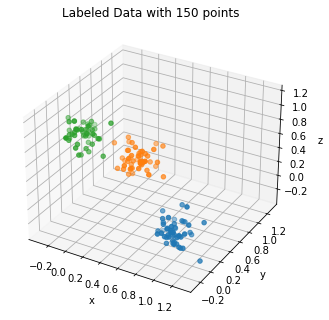

In [99]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N_each = 50 # Number of points in each cluster
M = n_cluster = 3 # Number of clusters = number of classes
N = N_each*n_cluster # Total number of points

mu, sigma = 0, 0.1 # mean and standard deviation
xs = np.random.normal(mu, sigma, N)
ys = np.random.normal(mu, sigma, N)
zs = np.random.normal(mu, sigma, N)

y = np.array([])
# Cluster centers: (1,0,0) (0,1,0) (0,0,1), (2,1,1), (1,2,1), (1,1,2), (3,2,2,), ...
for i in range(n_cluster):
    q = i // 3
    mod = i % 3
    
    if mod == 0:
        xs[N_each*i:N_each*(i+1)] += 1;
    if mod == 1:
        ys[N_each*i:N_each*(i+1)] += 1;
    if mod == 2:
        zs[N_each*i:N_each*(i+1)] += 1;
    xs[N_each*i:N_each*(i+1)] += q;
    ys[N_each*i:N_each*(i+1)] += q;
    zs[N_each*i:N_each*(i+1)] += q;
    y = np.append(y, i*np.ones(N_each))
    
Data = np.array([xs,ys,zs]).T

Z_prime = np.array([0,20,40,50,60,80,100,130,140]) # Indices of labels
u_dagger = np.eye(n_cluster)[y.astype(int)].T # One-hot encoded 
cmap = plt.cm.get_cmap('hsv', N)

# Display plot
fig = plt.figure()
ax = Axes3D(fig)
for i in range(n_cluster):
    ax.scatter(xs[i*N_each:(i+1)*N_each], ys[i*N_each:(i+1)*N_each], zs[i*N_each:(i+1)*N_each], cmap(i))
ax.set_title('Labeled Data with ' + str(N) +' points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.show()

In [100]:
from time import perf_counter

# Initial Parameters
eps = 0.15
rval = 0.25 #threshold for kernel
tau = 1
alpha = 1
g = 0.5 #Noise standard deviation
n_eig = 20 #(62) truncation

time_start = perf_counter()
u_ast = u_ast_EL(Data, N, M, g, y, Z_prime, alpha, tau, eps, rval)
print("Runtime for EL: " + str(perf_counter() - time_start))
pred_error =  sum(abs(np.argmax(u_ast, axis=0)-y))/(2*N)*100
print("Error for EL: " + str(pred_error))


Runtime for EL: 240.57854535800016
Error for EL: 0.0


In [101]:
time_start = perf_counter()
u_ast2 = u_ast_reduced_EL(Data, N, M, g, y, Z_prime, alpha, tau, eps, rval)
print("Runtime for truncated EL: " + str(perf_counter() - time_start))
pred_error =  sum(abs(np.argmax(u_ast2, axis=0)-y))/(2*N)*100
print("Error for EL: " + str(pred_error))

Runtime for truncated EL: 12.003210670000044
Error for EL: 0.0


## Using Kernel Flow method 

In [137]:
# Using Kernel Flow method to approximate parameters

# Return randomly selected half data indices from N that includes half of
# labeled data
# Follows from [1]
def select_Nf(N, Z_prime):
    '''
    N - (int) number of elements
    Z_prime - indices of labeled data
    '''
    N_f = int((N-Z_prime.size)/2) # Must be <= N
    half_Z = int(Z_prime.size/2+1) # half of labels

    # Randomly selected indices N_f and N_c used for X,Y,Z
    # Always need to include Z' or else cant compute
    N_f_i = np.random.choice(N, N_f, replace=False)
    Z_half= np.random.choice(Z_prime, half_Z, replace=False)
    for z in Z_half:
        if z not in N_f_i:
            N_f_i = np.append(N_f_i, z)

    N_f = N_f_i.size
    return N_f_i, Z_half

# Follows rho expression given in [2]-(6)
def rho_EL(g, alpha, tau, eps, rval):
    '''
    theta - parameters to optimize (g, alpha, tau, eps, rval)
    X - whole data (not just half)
    N - (int) number of elements
    Z_prime - indices of labeled data
    y - labels (of Z_prime)
    '''
    # g = 0.15; alpha = 1.; tau = 1.;
    # eps, rval= theta

    N_f_i, Z_half = select_Nf(N, Z_prime)

#     uast = u_ast_EL(Data, N, M, g, y, Z_prime, alpha, tau, eps, rval)
#     uast_tild = u_ast_EL(Data, N_f_i, Z_half.size, g, y, Z_half, alpha, tau, eps, rval)
    uast = u_ast_reduced_EL(Data, N, M, g, y, Z_prime, alpha, tau, eps, rval)
    uast_tild = u_ast_reduced_EL(Data, N_f_i, M, g, y, Z_half, alpha, tau, eps, rval)

    # Compute |uast-uast_tild|^2/|uast|^2 using L2 norm
    # loop over each valid N_f_i
    num = 0.0
    denom = 0.0
    # denominator sometimes becomes too small
    # normalize so that we can compute rho
#     uast = uast / uast.sum(axis=0, keepdims=1)
#     uast_tild = uast_tild / uast_tild.sum(axis=0, keepdims=1)
    for u_i, nf_i in enumerate(N_f_i):
        num += np.linalg.norm(uast_tild[:,u_i] - uast[:,nf_i])
        denom += np.linalg.norm(uast[:,nf_i])
    print(denom)
    return - num/denom

In [138]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

zeros = 1e-6
pbounds = {'g': (zeros,2), 'alpha':(zeros,4), 'tau':(zeros,4), 'eps':(zeros,2), 'rval':(zeros,1)}
optimizer_EL = BayesianOptimization(
    f=rho_EL,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)
print("Optimizer for Euler-Lagrange equations")
# flip (rho) minimize --> (- rho) maximize
optimizer_EL.maximize(
    init_points=3,
    n_iter=10,
)

Optimizer for Euler-Lagrange equations
|   iter    |  target   |   alpha   |    eps    |     g     |   rval    |    tau    |
-------------------------------------------------------------------------------------


/opt/anaconda3/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
<ipython-input-61-ccf70c7181f5>:21: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/g*np.exp(-1.0/g*X)*np.reciprocal(np.exp(-1.0/g*X)+1)**2
<ipython-input-61-ccf70c7181f5>:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  y, err = quad(multi_psi_int, tmin, tmax, args=(v,m,g))
<ipython-input-61-ccf70c7181f5>:52: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  y, err = quad(multi_partial_int, tmin, tmax, args=(v,m,k,g))
<ipython-input-61-ccf70c7181f5>:47: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The

0.0
|  1        |  nan      |  1.668    |  1.441    |  0.000229 |  0.3023   |  0.587    |


<ipython-input-137-9365a6eafb25>:56: RuntimeWarning: invalid value encountered in double_scalars
  return - num/denom


3.5154128516027976
|  2        | -1.516    |  0.3694   |  0.3725   |  0.6911   |  0.3968   |  2.155    |
1.0973632309520463e-06
|  3        | -3.403e+0 |  1.677    |  1.37     |  0.4089   |  0.8781   |  0.1096   |


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').